In [228]:
import pandas as pd
import numpy as np
import missingno as msno
import impyute as impy
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
import copy
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from scikit_posthocs import posthoc_nemenyi_friedman
import caffeine
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import timeit
from xgboost import plot_tree
import matplotlib.pyplot as plt

In [157]:
train=pd.read_csv('train.csv',index_col=0)

In [158]:
X_train=train.loc[:, train.columns!='LET_IS']
y_train = train['LET_IS']

In [221]:
test=pd.read_csv('test.csv',index_col=0)
X_test=train.loc[:, train.columns!='LET_IS']
y_test= train['LET_IS']

In [215]:
binary=['SEX',
 'SIM_GIPERT',
 'nr_11',
 'nr_01',
 'nr_02',
 'nr_03',
 'nr_04',
 'nr_07',
 'nr_08',
 'np_01',
 'np_04',
 'np_05',
 'np_07',
 'np_08',
 'np_09',
 'np_10',
 'endocr_01',
 'endocr_02',
 'endocr_03',
 'zab_leg_01',
 'zab_leg_02',
 'zab_leg_03',
 'zab_leg_04',
 'zab_leg_06',
 'O_L_POST',
 'K_SH_POST',
 'MP_TP_POST',
 'SVT_POST',
 'GT_POST',
 'FIB_G_POST',
 'IM_PG_P',
 'ritm_ecg_p_01',
 'ritm_ecg_p_02',
 'ritm_ecg_p_04',
 'ritm_ecg_p_06',
 'ritm_ecg_p_07',
 'ritm_ecg_p_08',
 'n_r_ecg_p_01',
 'n_r_ecg_p_02',
 'n_r_ecg_p_03',
 'n_r_ecg_p_04',
 'n_r_ecg_p_05',
 'n_r_ecg_p_06',
 'n_r_ecg_p_08',
 'n_r_ecg_p_09',
 'n_r_ecg_p_10',
 'n_p_ecg_p_01',
 'n_p_ecg_p_03',
 'n_p_ecg_p_04',
 'n_p_ecg_p_05',
 'n_p_ecg_p_06',
 'n_p_ecg_p_07',
 'n_p_ecg_p_08',
 'n_p_ecg_p_09',
 'n_p_ecg_p_10',
 'n_p_ecg_p_11',
 'n_p_ecg_p_12',
 'fibr_ter_01',
 'fibr_ter_02',
 'fibr_ter_03',
 'fibr_ter_05',
 'fibr_ter_06',
 'fibr_ter_07',
 'fibr_ter_08',
 'GIPO_K',
 'GIPER_NA',
 'NA_KB',
 'NOT_NA_KB',
 'LID_KB',
 'NITR_S',
 'LID_S_n',
 'B_BLOK_S_n',
 'ANT_CA_S_n',
 'GEPAR_S_n',
 'ASP_S_n',
 'TIKL_S_n',
 'TRENT_S_n']
cato=['INF_ANAM',
 'STENOK_AN',
 'FK_STENOK',
 'IBS_POST',
 'GB',
 'DLIT_AG',
 'ZSN_A',
 'ant_im',
 'lat_im',
 'inf_im',
 'post_im',
 'TIME_B_S']
continuous=['AGE',
 'S_AD_ORIT',
 'D_AD_ORIT',
 'K_BLOOD',
 'NA_BLOOD',
 'ALT_BLOOD',
 'AST_BLOOD',
 'L_BLOOD',
 'ROE']
numerical=cato+continuous 

In [160]:
#This is the imputation step; made in the other code.
X_train.update(pd.DataFrame(impy.median(X_train[binary+cato].to_numpy()), index=X_train[binary+cato].index,columns=X_train[binary+cato].columns))
X_train.update(pd.DataFrame(impy.mice(X_train[continuous].to_numpy()), index=X_train[continuous].index,columns=X_train[continuous].columns))

In [222]:
X_test.update(pd.DataFrame(impy.median(X_test[binary+cato].to_numpy()), index=X_test[binary+cato].index,columns=X_test[binary+cato].columns))
X_test.update(pd.DataFrame(impy.mice(X_test[continuous].to_numpy()), index=X_test[continuous].index,columns=X_test[continuous].columns))

# Hyperparameter Optimization
Using the outcomes of the base classifiers in the imputation section of our code; we have decided to tune a Logistic Regression Classifier, and K Nearest Neighbor Classifier. We also want to try the ensemble learner XGBoost to see if it can also provide good results.

In [23]:
#We want to use Stratified K Fold for our dataset because we have many features that are unbalanced.
#Stratified K Fold makes sure that each class is represented.
#This cross validation split will be used to iterate over multiple RandomizedSearchCV or GridSearchCV
cv_outer= StratifiedKFold(n_splits=15, shuffle=True, random_state=1)
#This cross validation split will be used within the RandomizedSearchCV and GridSearchCV
cv_inner= StratifiedKFold(n_splits=25, shuffle=True, random_state=1)

In [24]:
#Here is where we initilize the XGBoost Classifier, set optimization parameters not hyperparameters
#Objective has three options:multi:softmax,multi:softprob, binary:logistic
#We use binary:logistic because our target feature is binary.

model_xgb = xgb.XGBClassifier(objective='binary:logistic',eval_metric='logloss', use_label_encoder=False,seed=1)

xgb_pipeline = Pipeline([ 
    ('model_xgb', model_xgb)
])

# The search space for hyperparameters were found in xgboost documentation and some help for this webpage: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
xgb_param= {
    'model_xgb__max_depth': range(2,20),
    'model_xgb__min_child_weight':range(1,10),
    'model_xgb__gamma':[i/10.0 for i in range(0,5)],
    'model_xgb__subsample':[i/10.0 for i in range(6,10)],
    'model_xgb__colsample_bytree':[i/10.0 for i in range(6,10)],
    'model_xgb__reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
    }
xgb_random = RandomizedSearchCV(xgb_pipeline, xgb_param, cv=cv_inner, scoring='f1', random_state=1)

In [25]:
#Logistic Regression 
log = LogisticRegression(random_state=0)
log_pipeline=Pipeline([  
    ('log',log)
])
#The hyperparameter penalty heavly influences the rest of the choices because most of the solvers can not deal with l2 penality.
#We thought the l2 was something to see if it worked with our dataset so we choose to include it 
log_param={
            'log__penalty':['l1', 'l2'],
            'log__solver':['liblinear','saga'],
            'log__C':[0.001,0.01,0.1,1,10,100, 1000],
            'log__max_iter':[10000],
            'log__fit_intercept':[True,False],
}

log_random=RandomizedSearchCV(log_pipeline, log_param, cv=cv_inner, scoring='f1', random_state=1)

In [26]:
#K Nearest Neighbor Classifier
neigh = KNeighborsClassifier()
neigh_pipeline = Pipeline([ 
    ('neigh', neigh)
])
#These hyperparaters were chosen from the sklearn documentation
# metric and metric_params were excluded because of lack of understanding of there use
#n_jobs is said in the documentation to not affect fit, and only affect computation
neigh_param = {
                'neigh__n_neighbors': range(1,round(len(X_train)*0.6)),
                'neigh__leaf_size': range(len(X_train)),
                'neigh__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                'neigh__weights': ['uniform', 'distance'],
                'neigh__p': [1,2],
                
}

neigh_random = RandomizedSearchCV(neigh_pipeline, neigh_param, cv=cv_inner, scoring='f1', random_state=1)

In [27]:
#This block of code is our first attempt to find the best hyperparameters and how those preform on the training dataset
caffeine.on(display=True)
xgb_outer_results = list()
xgb_best_recall=float('-inf')
xgb_best_parameters={}

log_outer_results = list()
log_best_recall=float('-inf')
log_best_parameters={}

knn_outer_results = list()
knn_best_recall=float('-inf')
knn_best_parameters={}

iter_num=1
for train_ix, test_ix in cv_outer.split(X_train, y_train):
    print('Iteration',iter_num)
    iter_num +=1
    # Split data for inner 
    X_traini, X_testi = X_train.iloc[train_ix, :], X_train.iloc[test_ix, :]
    y_traini, y_testi = y_train.iloc[train_ix], y_train.iloc[test_ix]
    #XGBoost
    result=xgb_random.fit(X_traini, y_traini)
    best_model = result.best_estimator_
    y_pred = best_model.predict(X_testi)
    f1score=f1_score(y_testi,y_pred)
    recall=recall_score(y_testi,y_pred)
    auc=roc_auc_score(y_testi,y_pred)
    if recall >= xgb_best_recall:
        xgb_best_recall=recall
        xgb_best_parameters=result.best_params_
    xgb_outer_results.append([recall,f1score,auc])
    print("XGBoost F-1 Score: %f Recall: %f AUC: %f" %(f1score,recall,auc))
    #Logistic Regression
    result=log_random.fit(X_traini, y_traini)
    best_model = result.best_estimator_
    y_pred = best_model.predict(X_testi)
    f1score=f1_score(y_testi,y_pred)
    recall=recall_score(y_testi,y_pred)
    auc=roc_auc_score(y_testi,y_pred)
    if recall >= log_best_recall:
        log_best_recall=recall
        log_best_parameters=result.best_params_
    log_outer_results.append([recall,f1score,auc])
    print("Logistic Regression F-1 Score: %f Recall: %f AUC: %f" %(f1score,recall,auc))
    #K Nearest Neighbor Classifier
    result=neigh_random.fit(X_traini, y_traini)
    best_model = result.best_estimator_
    y_pred = best_model.predict(X_testi)
    f1score=f1_score(y_testi,y_pred)
    recall=recall_score(y_testi,y_pred)
    auc=roc_auc_score(y_testi,y_pred)
    if recall >= knn_best_recall:
        knn_best_recall=recall
        knn_best_parameters=result.best_params_
    knn_outer_results.append([recall,f1score,auc])
    print("K Nearest Neighbor Classifier F-1 Score: %f Recall: %f AUC: %f" %(f1score,recall,auc))
log_mean=np.mean(log_outer_results)
xgb_mean=np.mean(xgb_outer_results)
knn_mean=np.mean(knn_outer_results)
print('Logistic Regression outer test: recall mean: %f (std: %f)' % (log_mean, np.std(log_outer_results)))
print('XGB outer test: recall mean: %f (std: %f)' % (xgb_mean, np.std(xgb_outer_results)))
print('K Nearest Neighbor Classifier​ outer test: recall mean: %f (std: %f)' % (knn_mean, np.std(knn_outer_results)))
caffeine.off()

Iteration 1
XGBoost F-1 Score: 0.380952 Recall: 0.285714 AUC: 0.623377
Logistic Regression F-1 Score: 0.454545 Recall: 0.357143 AUC: 0.659091
K Nearest Neighbor Classifier F-1 Score: 0.117647 Recall: 0.071429 AUC: 0.522727
Iteration 2
XGBoost F-1 Score: 0.416667 Recall: 0.357143 AUC: 0.646104
Logistic Regression F-1 Score: 0.461538 Recall: 0.428571 AUC: 0.675325
K Nearest Neighbor Classifier F-1 Score: 0.300000 Recall: 0.214286 AUC: 0.587662
Iteration 3
XGBoost F-1 Score: 0.434783 Recall: 0.357143 AUC: 0.652597
Logistic Regression F-1 Score: 0.583333 Recall: 0.500000 AUC: 0.730519
K Nearest Neighbor Classifier F-1 Score: 0.352941 Recall: 0.214286 AUC: 0.607143
Iteration 4
XGBoost F-1 Score: 0.454545 Recall: 0.333333 AUC: 0.653509
Logistic Regression F-1 Score: 0.260870 Recall: 0.200000 AUC: 0.567105
K Nearest Neighbor Classifier F-1 Score: 0.222222 Recall: 0.133333 AUC: 0.560088
Iteration 5
XGBoost F-1 Score: 0.666667 Recall: 0.533333 AUC: 0.760088
Logistic Regression F-1 Score: 0.5000

In [28]:
defaulttParm={}
for k in xgb_best_parameters.keys():
    if 'model_xgb' in k:
        parm=k.split('__')[1]
        defaulttParm[parm]=xgb_best_parameters[k]
defaulttParm['use_label_encoder']=False
myFinalModel=xgb.XGBClassifier(**defaulttParm)

In [29]:
print(myFinalModel)

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.9,
              enable_categorical=False, gamma=0.4, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=7,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=1e-05,
              reg_lambda=None, scale_pos_weight=None, subsample=0.7,
              tree_method=None, use_label_encoder=False,
              validate_parameters=None, verbosity=None)


In [191]:
# As can be seen in the results above XGBoost was a model that preformed very well.
# We wanted to see is an exaustive grid search around the outcomes of previous best model could continue to improve results
model_xgb = xgb.XGBClassifier(objective='binary:logistic',eval_metric='logloss', use_label_encoder=False,seed=1)

xgb_pipeline = Pipeline([ 
    ('model_xgb', model_xgb)
])

# The search space for hyperparameters were found in xgboost documentation and some help for this webpage: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
xgb_param= {
    'model_xgb__max_depth': range(5,10),
    'model_xgb__min_child_weight':range(1,4),
    'model_xgb__gamma':[i/10.0 for i in range(3,6)],
    'model_xgb__subsample':[i/10.0 for i in range(6,8)],
    'model_xgb__colsample_bytree':[i/10.0 for i in range(8,10)],
    'model_xgb__reg_alpha':[1e-6,1e-5, 1e-4],
    }

xgb_exhaustive = GridSearchCV(xgb_pipeline, xgb_param, cv=cv_inner, scoring='f1')

In [ ]:
start = timeit.default_timer()
caffeine.on(display=True)
xgb2_outer_results = list()
xgb2_best_recall=float('-inf')
xgb2_best_parameters={}
iter_num=1
for train_ix, test_ix in cv_outer.split(X_train, y_train):
    print('Iteration',iter_num)
    iter_num +=1
    # Split data for inner 
    X_traini, X_testi = X_train.iloc[train_ix, :], X_train.iloc[test_ix, :]
    y_traini, y_testi = y_train.iloc[train_ix], y_train.iloc[test_ix]
    #XGBoost
    result=xgb_exhaustive.fit(X_traini, y_traini)
    best_model = result.best_estimator_
    y_pred = best_model.predict(X_testi)
    f1score=f1_score(y_testi,y_pred)
    recall=recall_score(y_testi,y_pred)
    auc=roc_auc_score(y_testi,y_pred)
    if recall >= xgb2_best_recall:
        xgb2_best_recall=recall
        xgb2_best_parameters=result.best_params_
    xgb2_outer_results.append([recall,f1score,auc])
    print("XGBoost F-1 Score: %f Recall: %f AUC: %f" %(f1score,recall,auc))
xgb2_mean=np.mean(xgb2_outer_results)
print('XGB outer test: recall mean: %f (std: %f)' % (xgb2_mean, np.std(xgb2_outer_results)))
caffeine.off()
stop = timeit.default_timer()

print('Time: ', stop - start) 

In [32]:
defaulttParm2={}
for k in xgb2_best_parameters.keys():
    if 'model_xgb' in k:
        parm=k.split('__')[1]
        defaulttParm2[parm]=xgb2_best_parameters[k]
defaulttParm2['use_label_encoder']=False
myFinalModel2=xgb.XGBClassifier(**defaulttParm2)
print(myFinalModel2)

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.8,
              enable_categorical=False, gamma=0.4, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=7,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=1e-06,
              reg_lambda=None, scale_pos_weight=None, subsample=0.6,
              tree_method=None, use_label_encoder=False,
              validate_parameters=None, verbosity=None)


### This was our first attempts at finding the best models and getting an understanding of how well this data could be classified. After our feature selection analysis we wanted to see if the preformace was improved we only using the feature of most importance.

In [174]:
#This cell just takes out our feature that we selected
feature_filter=['AGE',
 'INF_ANAM',
 'STENOK_AN',
 'FK_STENOK',
 'IBS_POST',
 'GB',
 'DLIT_AG',
 'ZSN_A',
 'nr_03',
 'nr_08',
 'endocr_03',
 'S_AD_ORIT',
 'D_AD_ORIT',
 'O_L_POST',
 'K_SH_POST',
 'ant_im',
 'lat_im',
 'inf_im',
 'IM_PG_P',
 'ritm_ecg_p_01',
 'ritm_ecg_p_07',
 'n_r_ecg_p_08',
 'n_p_ecg_p_01',
 'n_p_ecg_p_08',
 'n_p_ecg_p_12',
 'K_BLOOD',
 'NA_BLOOD',
 'TIME_B_S',
 'NA_KB',
 'LID_KB']
X_train_fs=X_train[feature_filter]

In [175]:
#In our initial analysis these important steps were missed.
#For this section of the hyperparameter optimization we scale our continous data and get dummies for our categorical data that is not binary.
scalor=StandardScaler()
encoder = OneHotEncoder(handle_unknown='ignore')

In [163]:
#Updates lists to match feature selection
continuous.remove('ALT_BLOOD')
continuous.remove('AST_BLOOD')
continuous.remove('L_BLOOD')
continuous.remove('ROE')
cato.remove('post_im')

In [176]:
#Get Dummies appends new columns to the data set to help work with categories to improve the performace of models
encoder.fit(X_train_fs[cato])    
enc_df = pd.DataFrame(encoder.fit_transform(X_train_fs[cato]).toarray(),index=X_train_fs.index)
X_train_fs=X_train_fs.drop(columns=cato)
X_train_fs=X_train_fs.join(enc_df)


In [181]:
#This is the second attempt to optimize hyperparameters this time using feature selcected data, scaling, and get dummies.
start = timeit.default_timer()
caffeine.on(display=True)
xgb3_outer_results = list()
xgb3_best_recall=float('-inf')
xgb3_best_parameters={}

log3_outer_results = list()
log3_best_recall=float('-inf')
log3_best_parameters={}

knn3_outer_results = list()
knn3_best_recall=float('-inf')
knn3_best_parameters={}

iter_num=1

for train_ix, test_ix in cv_outer.split(X_train_fs, y_train):
    print('Iteration',iter_num)
    iter_num +=1
    # Split data for inner 
    X_traini, X_testi = X_train_fs.iloc[train_ix, :], X_train_fs.iloc[test_ix, :]
    y_traini, y_testi = y_train.iloc[train_ix], y_train.iloc[test_ix]
    #Scaling numeric features
    scalor.fit(X_traini[continuous])
    X_traini.update(pd.DataFrame(scalor.transform(X_traini[continuous]),index=X_traini[continuous].index,columns=continuous))
    X_testi.update(pd.DataFrame(scalor.transform(X_testi[continuous]),index=X_testi[continuous].index,columns=continuous))
    
    #XGBoost
    result=xgb_random.fit(X_traini, y_traini)
    best_model = result.best_estimator_
    y_pred = best_model.predict(X_testi)
    f1score=f1_score(y_testi,y_pred)
    recall=recall_score(y_testi,y_pred)
    auc=roc_auc_score(y_testi,y_pred)
    if recall >= xgb_best_recall:
        xgb3_best_recall=recall
        xgb3_best_parameters=result.best_params_
    xgb3_outer_results.append([recall,f1score,auc])
    print("XGBoost F-1 Score: %f Recall: %f AUC: %f" %(f1score,recall,auc))
    #Logistic Regression
    result=log_random.fit(X_traini, y_traini)
    best_model = result.best_estimator_
    y_pred = best_model.predict(X_testi)
    f1score=f1_score(y_testi,y_pred)
    recall=recall_score(y_testi,y_pred)
    auc=roc_auc_score(y_testi,y_pred)
    if recall >= log_best_recall:
        log3_best_recall=recall
        log3_best_parameters=result.best_params_
    log3_outer_results.append([recall,f1score,auc])
    print("Logistic Regression F-1 Score: %f Recall: %f AUC: %f" %(f1score,recall,auc))
    #K Nearest Neighbor Classifier
    result=neigh_random.fit(X_traini, y_traini)
    best_model = result.best_estimator_
    y_pred = best_model.predict(X_testi)
    f1score=f1_score(y_testi,y_pred)
    recall=recall_score(y_testi,y_pred)
    auc=roc_auc_score(y_testi,y_pred)
    if recall >= knn_best_recall:
        knn3_best_recall=recall
        knn3_best_parameters=result.best_params_
    knn3_outer_results.append([recall,f1score,auc])
    print("K Nearest Neighbor Classifier F-1 Score: %f Recall: %f AUC: %f" %(f1score,recall,auc))
log3_mean=np.mean(log3_outer_results)
xgb3_mean=np.mean(xgb3_outer_results)
knn3_mean=np.mean(knn3_outer_results)
print('Logistic Regression outer test: recall mean: %f (std: %f)' % (log3_mean, np.std(log3_outer_results)))
print('XGB outer test: recall mean: %f (std: %f)' % (xgb3_mean, np.std(xgb3_outer_results)))
print('K Nearest Neighbor Classifier outer test: recall mean: %f (std: %f)' % (knn3_mean, np.std(knn3_outer_results)))
caffeine.off()
stop = timeit.default_timer()

print('Time: ', stop - start)  


Iteration 1
XGBoost F-1 Score: 0.444444 Recall: 0.428571 AUC: 0.668831
Logistic Regression F-1 Score: 0.416667 Recall: 0.357143 AUC: 0.646104
K Nearest Neighbor Classifier F-1 Score: 0.000000 Recall: 0.000000 AUC: 0.500000
Iteration 2
XGBoost F-1 Score: 0.320000 Recall: 0.285714 AUC: 0.597403
Logistic Regression F-1 Score: 0.400000 Recall: 0.285714 AUC: 0.629870
K Nearest Neighbor Classifier F-1 Score: 0.250000 Recall: 0.142857 AUC: 0.571429
Iteration 3
XGBoost F-1 Score: 0.608696 Recall: 0.500000 AUC: 0.737013
Logistic Regression F-1 Score: 0.545455 Recall: 0.428571 AUC: 0.701299
K Nearest Neighbor Classifier F-1 Score: 0.000000 Recall: 0.000000 AUC: 0.500000
Iteration 4
XGBoost F-1 Score: 0.272727 Recall: 0.200000 AUC: 0.573684
Logistic Regression F-1 Score: 0.454545 Recall: 0.333333 AUC: 0.653509
K Nearest Neighbor Classifier F-1 Score: 0.125000 Recall: 0.066667 AUC: 0.533333
Iteration 5
XGBoost F-1 Score: 0.272727 Recall: 0.200000 AUC: 0.573684
Logistic Regression F-1 Score: 0.3809

In [183]:
#This block of code shows what xgboot model had the best preformace.
defaulttParm3={}
for k in xgb3_best_parameters.keys():
    if 'model_xgb' in k:
        parm=k.split('__')[1]
        defaulttParm3[parm]=xgb3_best_parameters[k]
defaulttParm3['use_label_encoder']=False
myFinalModel3=xgb.XGBClassifier(**defaulttParm3)
print(myFinalModel3)

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.9,
              enable_categorical=False, gamma=0.1, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=3,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=0.01,
              reg_lambda=None, scale_pos_weight=None, subsample=0.9,
              tree_method=None, use_label_encoder=False,
              validate_parameters=None, verbosity=None)


In [187]:
#This is another exhaustive grid search for xgboost to improve the model found after the randomized grid search
start = timeit.default_timer()
caffeine.on(display=True)
xgb4_outer_results = list()
xgb4_best_recall=float('-inf')
xgb4_best_parameters={}
iter_num=1
for train_ix, test_ix in cv_outer.split(X_train_fs, y_train):
    print('Iteration',iter_num)
    iter_num +=1
    # Split data for inner 
    X_traini, X_testi = X_train.iloc[train_ix, :], X_train.iloc[test_ix, :]
    y_traini, y_testi = y_train.iloc[train_ix], y_train.iloc[test_ix]
    #Scaling numeric features
    scalor.fit(X_traini[continuous])
    X_traini.update(pd.DataFrame(scalor.transform(X_traini[continuous]),index=X_traini[continuous].index,columns=continuous))
    X_testi.update(pd.DataFrame(scalor.transform(X_testi[continuous]),index=X_testi[continuous].index,columns=continuous))
    #XGBoost
    result=xgb_exhaustive.fit(X_traini, y_traini)
    best_model = result.best_estimator_
    y_pred = best_model.predict(X_testi)
    f1score=f1_score(y_testi,y_pred)
    recall=recall_score(y_testi,y_pred)
    auc=roc_auc_score(y_testi,y_pred)
    if recall >= xgb2_best_recall:
        xgb4_best_recall=recall
        xgb4_best_parameters=result.best_params_
    xgb4_outer_results.append([recall,f1score,auc])
    print("XGBoost F-1 Score: %f Recall: %f AUC: %f" %(f1score,recall,auc))
xgb4_mean=np.mean(xgb4_outer_results)
print('XGB outer test: recall mean: %f (std: %f)' % (xgb4_mean, np.std(xgb4_outer_results)))
caffeine.off()
stop = timeit.default_timer()

print('Time: ', stop - start)  

Iteration 1
XGBoost F-1 Score: 0.454545 Recall: 0.357143 AUC: 0.659091
Iteration 2
XGBoost F-1 Score: 0.428571 Recall: 0.428571 AUC: 0.662338
Iteration 3
XGBoost F-1 Score: 0.560000 Recall: 0.500000 AUC: 0.724026
Iteration 4
XGBoost F-1 Score: 0.260870 Recall: 0.200000 AUC: 0.567105
Iteration 5
XGBoost F-1 Score: 0.521739 Recall: 0.400000 AUC: 0.686842
Iteration 6
XGBoost F-1 Score: 0.560000 Recall: 0.466667 AUC: 0.713596
Iteration 7
XGBoost F-1 Score: 0.583333 Recall: 0.466667 AUC: 0.720175
Iteration 8
XGBoost F-1 Score: 0.583333 Recall: 0.466667 AUC: 0.720175
Iteration 9
XGBoost F-1 Score: 0.521739 Recall: 0.400000 AUC: 0.686842
Iteration 10
XGBoost F-1 Score: 0.583333 Recall: 0.466667 AUC: 0.720175
Iteration 11
XGBoost F-1 Score: 0.333333 Recall: 0.285714 AUC: 0.603383
Iteration 12
XGBoost F-1 Score: 0.521739 Recall: 0.428571 AUC: 0.694549
Iteration 13
XGBoost F-1 Score: 0.571429 Recall: 0.428571 AUC: 0.707707
Iteration 14
XGBoost F-1 Score: 0.454545 Recall: 0.357143 AUC: 0.658835
I

In [204]:
defaulttParm4={}
for k in xgb4_best_parameters.keys():
    if 'model_xgb' in k:
        parm=k.split('__')[1]
        defaulttParm4[parm]=xgb4_best_parameters[k]
defaulttParm4['use_label_encoder']=False
myFinalModel4=xgb.XGBClassifier(**defaulttParm4)
print(myFinalModel4)

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.8,
              enable_categorical=False, gamma=0.4, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=7,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=1e-06,
              reg_lambda=None, scale_pos_weight=None, subsample=0.6,
              tree_method=None, use_label_encoder=False,
              validate_parameters=None, verbosity=None)


In [185]:
#Logistic Regression also preformed well in the RamdomizedGridSearch and this exhaustive grid search looks to improve those results
log = LogisticRegression(random_state=0)
log_pipeline=Pipeline([  
    ('log',log)
])
log_param={
            'log__penalty':['l1', 'l2'],
            'log__solver':['liblinear','saga'],
            'log__C':[0.001,0.01,0.1,1,10,100, 1000],
            'log__max_iter':[10000],
            'log__fit_intercept':[True,False],
}

log_exhaustive = GridSearchCV(log_pipeline, log_param, cv=cv_inner, scoring='f1')

In [186]:
start = timeit.default_timer()
caffeine.on(display=True)
log4_outer_results = list()
log4_best_recall=float('-inf')
log4_best_parameters={}
iter_num=1
for train_ix, test_ix in cv_outer.split(X_train_fs, y_train):
    print('Iteration',iter_num)
    iter_num +=1
    # Split data for inner 
    X_traini, X_testi = X_train_fs.iloc[train_ix, :], X_train_fs.iloc[test_ix, :]
    y_traini, y_testi = y_train.iloc[train_ix], y_train.iloc[test_ix]
    #Scaling numeric features
    scalor.fit(X_traini[continuous])
    X_traini.update(pd.DataFrame(scalor.transform(X_traini[continuous]),index=X_traini[continuous].index,columns=continuous))
    X_testi.update(pd.DataFrame(scalor.transform(X_testi[continuous]),index=X_testi[continuous].index,columns=continuous))
    #Logistic Regression
    result=log_exhaustive.fit(X_traini, y_traini)
    best_model = result.best_estimator_
    y_pred = best_model.predict(X_testi)
    f1score=f1_score(y_testi,y_pred)
    recall=recall_score(y_testi,y_pred)
    auc=roc_auc_score(y_testi,y_pred)
    if recall >= log4_best_recall:
        log4_best_recall=recall
        log4_best_parameters=result.best_params_
    log4_outer_results.append([recall,f1score,auc])
    print("Logistic Regression F-1 Score: %f Recall: %f AUC: %f" %(f1score,recall,auc))
log4_mean=np.mean(log3_outer_results)
print('Logistic Regression outer test: recall mean: %f (std: %f)' % (log4_mean, np.std(log4_outer_results)))
caffeine.off()
stop = timeit.default_timer()

print('Time: ', stop - start)  

Iteration 1
Logistic Regression F-1 Score: 0.500000 Recall: 0.428571 AUC: 0.688312
Iteration 2
Logistic Regression F-1 Score: 0.400000 Recall: 0.285714 AUC: 0.629870
Iteration 3
Logistic Regression F-1 Score: 0.636364 Recall: 0.500000 AUC: 0.743506
Iteration 4
Logistic Regression F-1 Score: 0.454545 Recall: 0.333333 AUC: 0.653509
Iteration 5
Logistic Regression F-1 Score: 0.380952 Recall: 0.266667 AUC: 0.620175
Iteration 6
Logistic Regression F-1 Score: 0.689655 Recall: 0.666667 AUC: 0.807018
Iteration 7
Logistic Regression F-1 Score: 0.608696 Recall: 0.466667 AUC: 0.726754
Iteration 8
Logistic Regression F-1 Score: 0.545455 Recall: 0.400000 AUC: 0.693421
Iteration 9
Logistic Regression F-1 Score: 0.363636 Recall: 0.266667 AUC: 0.613596
Iteration 10
Logistic Regression F-1 Score: 0.400000 Recall: 0.333333 AUC: 0.633772
Iteration 11
Logistic Regression F-1 Score: 0.480000 Recall: 0.428571 AUC: 0.681391
Iteration 12
Logistic Regression F-1 Score: 0.666667 Recall: 0.571429 AUC: 0.772556
I

In [202]:
defaulttParm5={}
for k in log4_best_parameters.keys():
    if 'log' in k:
        parm=k.split('__')[1]
        defaulttParm5[parm]=log4_best_parameters[k]
myFinalModel5=LogisticRegression(**defaulttParm5, random_state=1)
print(myFinalModel5)

LogisticRegression(C=100, max_iter=10000, penalty='l1', random_state=1,
                   solver='liblinear')


### A further investigation into the hyperparameters that would well with l1 would be something we would like to further look into.

[08:45:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


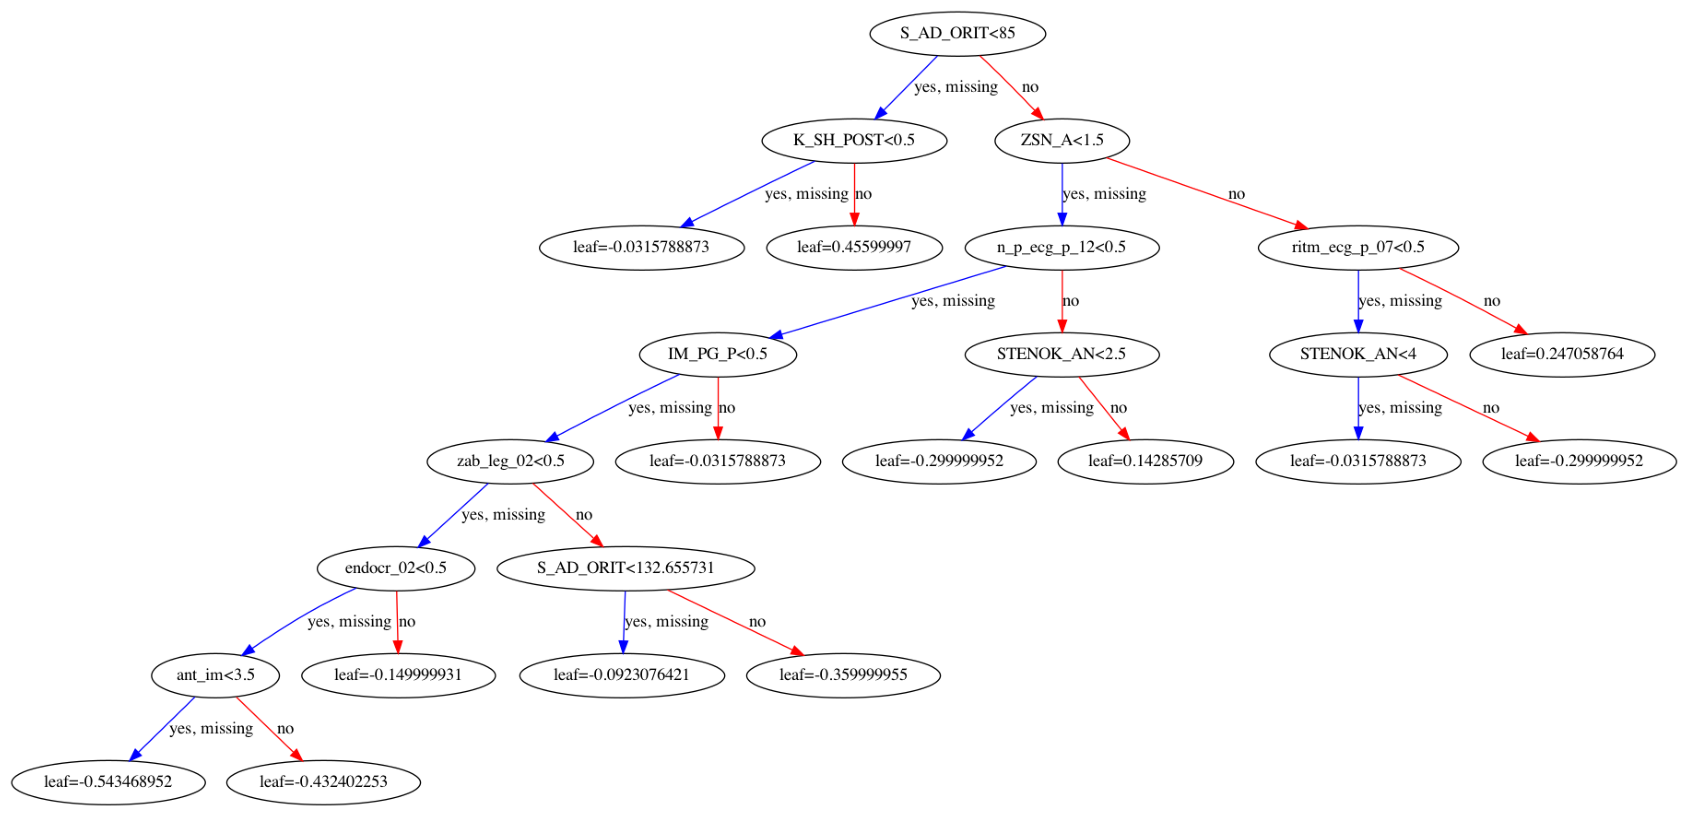

In [240]:
#This figure shows what XGBoost uses as key filters for its trees. We do a deeper evaulation using SHAP but this is just interesting.
myFinalModel2.fit(X_test, y_test)
fig, ax = plt.subplots(figsize=(30, 30))
plot_tree(myFinalModel2,ax=ax)
plt.show()

### Significance of Differences between models and Post-Hoc tests

In [265]:
#We want to check if the results between classifiers is significant for our first grid search
xgb_recall_results=[]
for x in xgb_outer_results:
    xgb_recall_results.append(x[1])
log_recall_results=[]
for x in log_outer_results:
    log_recall_results.append(x[1])
knn_recall_results=[]
for x in knn_outer_results:
    knn_recall_results.append(x[1])

In [268]:
groups=[xgb_recall_results,log_recall_results,knn_recall_results]
#Check if Friedman test is signifiant
chi_square,p_value=stats.friedmanchisquare(*groups)
print(p_value)
trans_groups=np.array(groups).T
#Friedman test is signifiant, pairwise posthoc_nemenyi_friedman
p=posthoc_nemenyi_friedman(trans_groups)
print(p)

5.747953574056122e-06
          0         1         2
0  1.000000  0.409304  0.001519
1  0.409304  1.000000  0.001000
2  0.001519  0.001000  1.000000


The above print out shows that XGBoost and Logistic Regression are not significantly different from each other but are better the KNearest Neighbors.

In [269]:
xgb3_recall_results=[]
for x in xgb3_outer_results:
    xgb3_recall_results.append(x[1])
log3_recall_results=[]
for x in log3_outer_results:
    log3_recall_results.append(x[1])
knn3_recall_results=[]
for x in knn3_outer_results:
    knn3_recall_results.append(x[1])

In [271]:
groups=[xgb3_recall_results,log3_recall_results,knn3_recall_results]
#Check if Friedman test is signifiant
chi_square,p_value=stats.friedmanchisquare(*groups)
print(p_value)
trans_groups=np.array(groups).T
#Friedman test is signifiant, pairwise posthoc_nemenyi_friedman
p=posthoc_nemenyi_friedman(trans_groups)
print(p)

7.55649236537242e-06
          0         1      2
0  1.000000  0.830185  0.001
1  0.830185  1.000000  0.001
2  0.001000  0.001000  1.000


The above print out shows that XGBoost and Logistic Regression are again not significantly different from each other but are better the KNearest Neighbors. This result affirms the decision to find the best hyperparameters for both XGBoost and Logistic Regression with an exhaustive grid search. Now we want to see if those experiments shown any improvement over each other.

In [272]:
xgb4_recall_results=[]
for x in xgb4_outer_results:
    xgb4_recall_results.append(x[1])
log4_recall_results=[]
for x in log4_outer_results:
    log4_recall_results.append(x[1])

In [275]:
groups=[xgb4_recall_results,log4_recall_results]
trans_groups=np.array(groups).T
#Pairwise posthoc_nemenyi_friedman
p=posthoc_nemenyi_friedman(trans_groups)
print(p)

          0         1
0  1.000000  0.615221
1  0.615221  1.000000


In [276]:
xgb4_f1_results=[]
for x in xgb4_outer_results:
    xgb4_f1_results.append(x[0])
log4_f1_results=[]
for x in log4_outer_results:
    log4_f1_results.append(x[0])

In [277]:
groups=[xgb4_f1_results,log4_f1_results]
trans_groups=np.array(groups).T
#Pairwise posthoc_nemenyi_friedman
p=posthoc_nemenyi_friedman(trans_groups)
print(p)

          0         1
0  1.000000  0.615221
1  0.615221  1.000000


In [278]:
xgb4_auc_results=[]
for x in xgb4_outer_results:
    xgb4_auc_results.append(x[2])
log4_auc_results=[]
for x in log4_outer_results:
    log4_auc_results.append(x[2])

In [279]:
groups=[xgb4_auc_results,log4_auc_results]
trans_groups=np.array(groups).T
#Pairwise posthoc_nemenyi_friedman
p=posthoc_nemenyi_friedman(trans_groups)
print(p)

          0         1
0  1.000000  0.301698
1  0.301698  1.000000


The above results show that there is not a significant difference between the two models running these experiments.

### Results

In [219]:
X_test=X_test[feature_filter]

In [255]:
myFinalModel4.fit(X_train,y_test)
y_pred=myFinalModel4.predict(X_test)
f1score=f1_score(y_test,y_pred)
recall=recall_score(y_test,y_pred)
auc=roc_auc_score(y_test,y_pred)
print('On Test F1_Score: %.6f, Recall: %.6f, AUC:%.6f' % (f1score,recall,auc))
y_pred=myFinalModel4.predict(X_train)
f1score=f1_score(y_train,y_pred)
recall=recall_score(y_train,y_pred)
auc=roc_auc_score(y_train,y_pred)
print('On Test F1_Score: %.6f, Recall: %.6f, AUC:%.6f' % (f1score,recall,auc))

[09:40:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
On Test F1_Score: 0.988345, Recall: 0.976959, AUC:0.988479
On Test F1_Score: 1.000000, Recall: 1.000000, AUC:1.000000


In [256]:
myFinalModel5.fit(X_train,y_test)
y_pred=myFinalModel5.predict(X_test)
f1score=f1_score(y_test,y_pred)
recall=recall_score(y_test,y_pred)
auc=roc_auc_score(y_test,y_pred)
print('F1_Score: %.6f, Recall: %.6f, AUC:%.6f' % (f1score,recall,auc))
myFinalModel5.fit(X_train,y_test)
y_pred=myFinalModel5.predict(X_train)
f1score=f1_score(y_train,y_pred)
recall=recall_score(y_train,y_pred)
auc=roc_auc_score(y_train,y_pred)
print('F1_Score: %.6f, Recall: %.6f, AUC:%.6f' % (f1score,recall,auc))

F1_Score: 0.636119, Recall: 0.543779, AUC:0.756141
F1_Score: 0.637838, Recall: 0.543779, AUC:0.756579


### These results suggest that our best XGBoost model must be overfitted to the training dataset while our best Logistic Reggression model looks to not be overfitted to the data. The best Logistic Reggression model might be underfitted because it does not produce very good results. 